# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 42

## Student 1 
### Name : Otte van Dam
### ID : 5096790

## Student 2
### Name : Suhaib Basir
### ID : 5059151

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

We split the inidivual and collaborative tasks into separate notebooks. This notebook contains task 1 and 4 while lab3_LSH and lab3_sketching_final contain the Min-wise locality sensitive hashing and Sketching task respectively. 

The total word count across all notebooks is 1511

In [228]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nbformat
from tqdm import tqdm
from flexfringe import FlexFringe
from sklearn.metrics.pairwise import cosine_similarity



nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 663


## 1. Familiarization and discretization task

In [61]:
# Specify the columns you want to read as strings
string_columns = ['sTos', 'dTos']

# Specify the columns you want to read as strings
data9 = "dataset_lab3/dataset_9/capture20110817.binetflow"
data10 = "dataset_lab3/dataset_10/capture20110818.binetflow"
data11 = "dataset_lab3/dataset_11/capture20110818-2.binetflow"
data12 = "dataset_lab3/dataset_12/capture20110819.binetflow"

df9 = pd.read_csv(data9, dtype={col: str for col in string_columns})
df10 = pd.read_csv(data10, dtype={col: str for col in string_columns})
df11 = pd.read_csv(data11, dtype={col: str for col in string_columns})
df12 = pd.read_csv(data12, dtype={col: str for col in string_columns})


infected_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193','147.32.84.204', '147.32.84.205', '147.32.84.206','147.32.84.207', '147.32.84.208', '147.32.84.209']

In [62]:
def discretise_netflow(df1):
    df1['bytes_per_second'] = df1['SrcBytes'] / (df1['Dur'] + 1e-10)

    # Discretize numeric columns using percentiles
    for column in df1.columns:
        if df1[column].dtype == np.float64 or df1[column].dtype == np.int64:
            df1[column] = pd.qcut(df1[column], q=20, labels=False, duplicates='drop')

    return df1

df9 = discretise_netflow(df9)
df10 = discretise_netflow(df10)
df11 = discretise_netflow(df11)
df12 = discretise_netflow(df12)

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [63]:
# Filter columns that are either integers or floats
numeric_cols_infected = df10[df10['SrcAddr'] == infected_hosts[1]].select_dtypes(include=['int', 'float'])
numeric_cols_other = df10[df10['SrcAddr'] != infected_hosts[1]].select_dtypes(include=['int', 'float'])

# Calculate the average and standard deviation for df_srcaddr_147
avg_values_infected = numeric_cols_infected.mean()
std_values_infected = numeric_cols_infected.std()
print(f'calculated for infected')

# Calculate the average and standard deviation for df_srcaddr_other
avg_values_other = numeric_cols_other.mean()
std_values_other = numeric_cols_other.std()
print('calculated for other')

# Print the average and standard deviation side by side
print(f"{'Column':<15} {'Average (infected)':<15} {'Std Deviation (infected)':<20} {'Average (Other)':<15} {'Std Deviation (Other)':<20}")
print("-" * 90)
for column in avg_values_infected.index:
    avg_infected = avg_values_infected[column]
    std_infected = std_values_infected[column]
    avg_other = avg_values_other[column]
    std_other = std_values_other[column]
    print(f"{column:<15} {avg_infected:<15.2f} {std_infected:<20.2f} {avg_other:<15.2f} {std_other:<20.2f}")

calculated for infected
calculated for other
Column          Average (infected) Std Deviation (infected) Average (Other) Std Deviation (Other)
------------------------------------------------------------------------------------------
Dur             1.68            5.06                 8.60            5.66                
TotPkts         0.29            1.33                 1.74            2.63                
TotBytes        11.31           1.07                 7.54            4.89                
SrcBytes        13.32           1.14                 7.93            5.09                
bytes_per_second 16.45           4.67                 9.39            5.66                


for infected: 


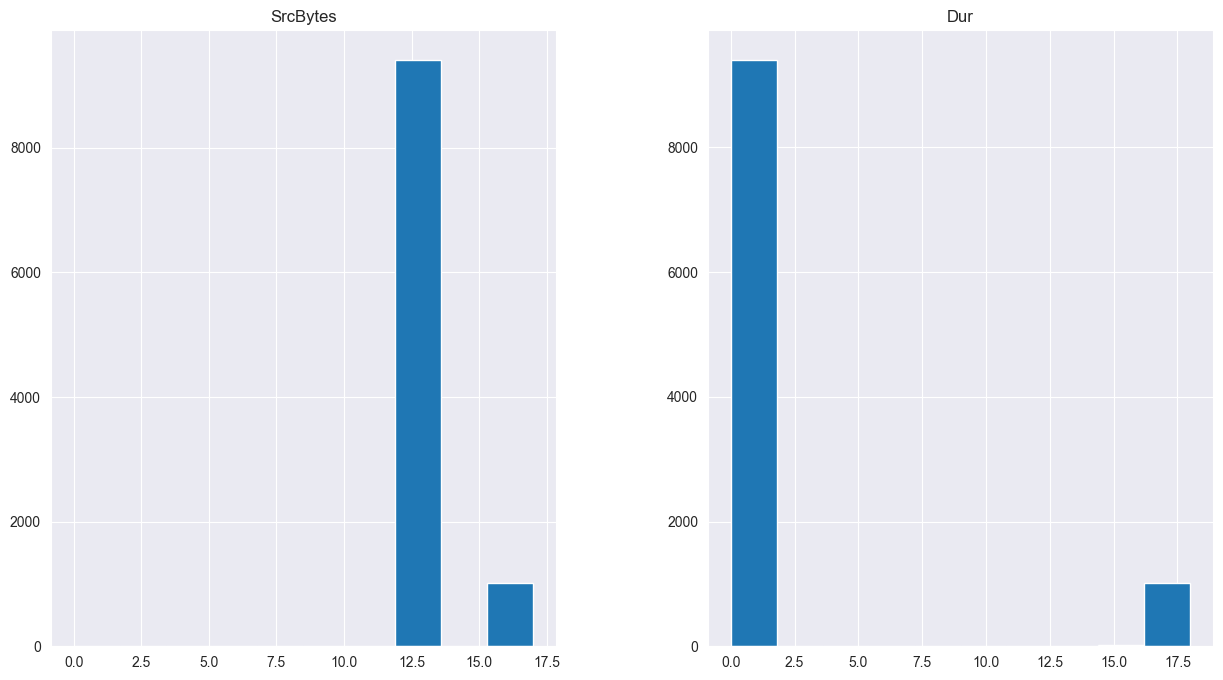

for normal: 


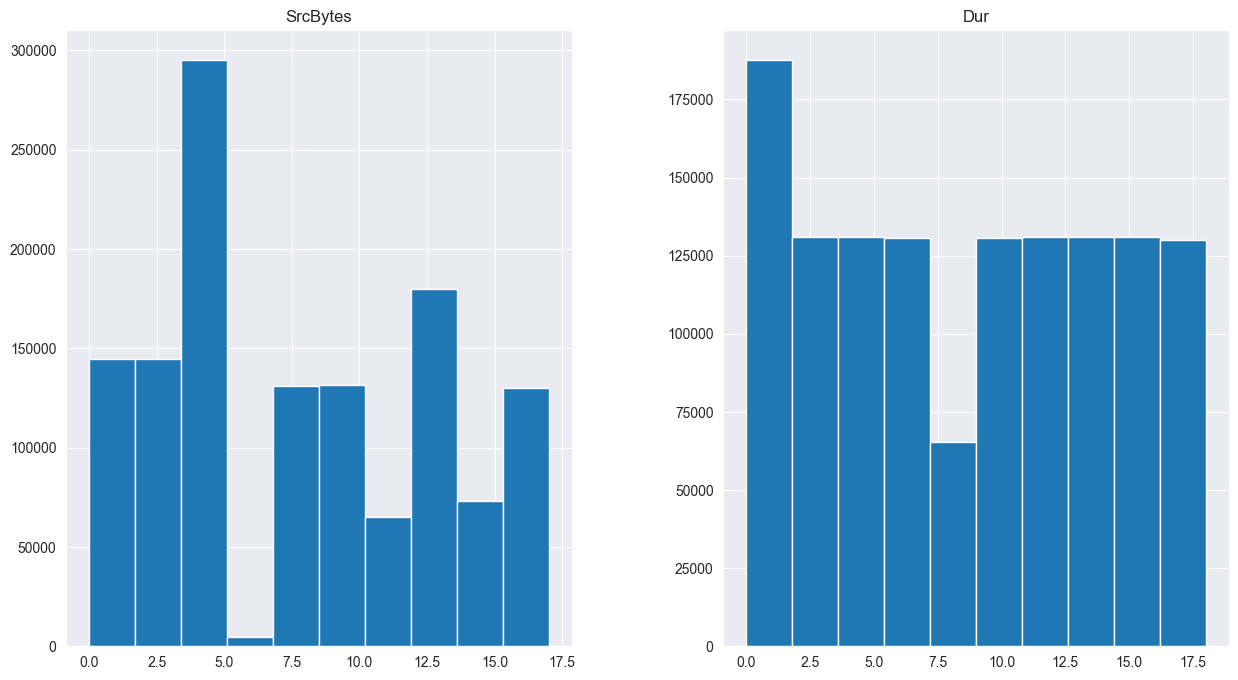

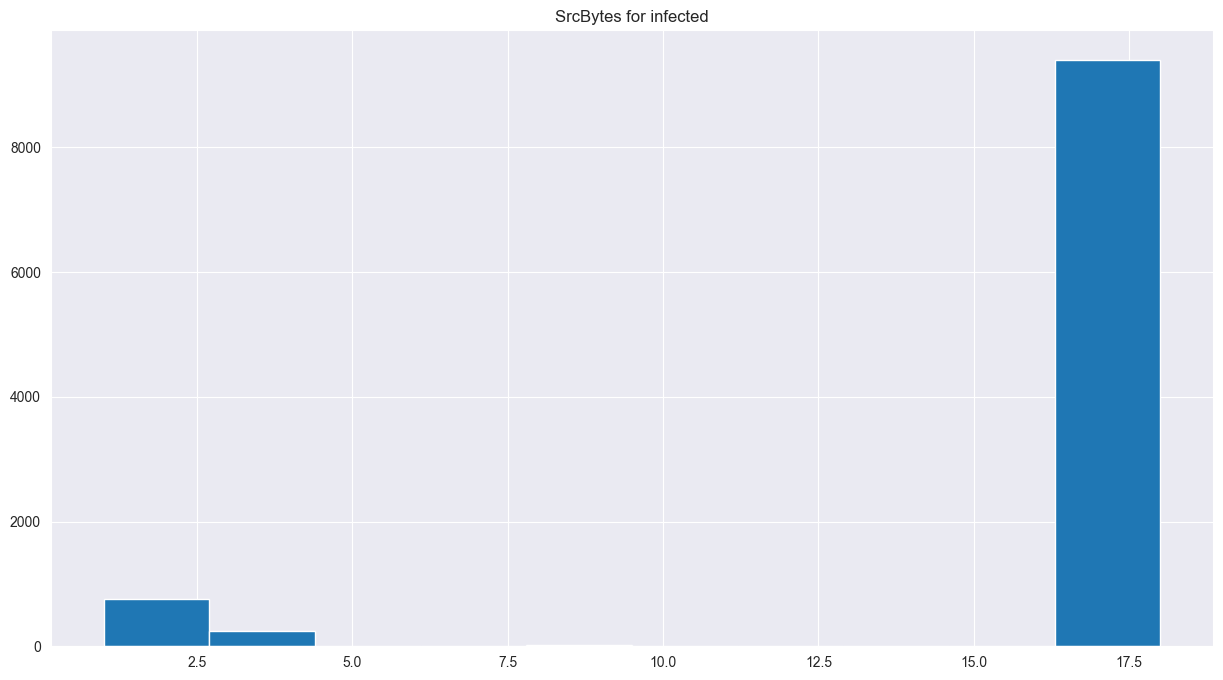

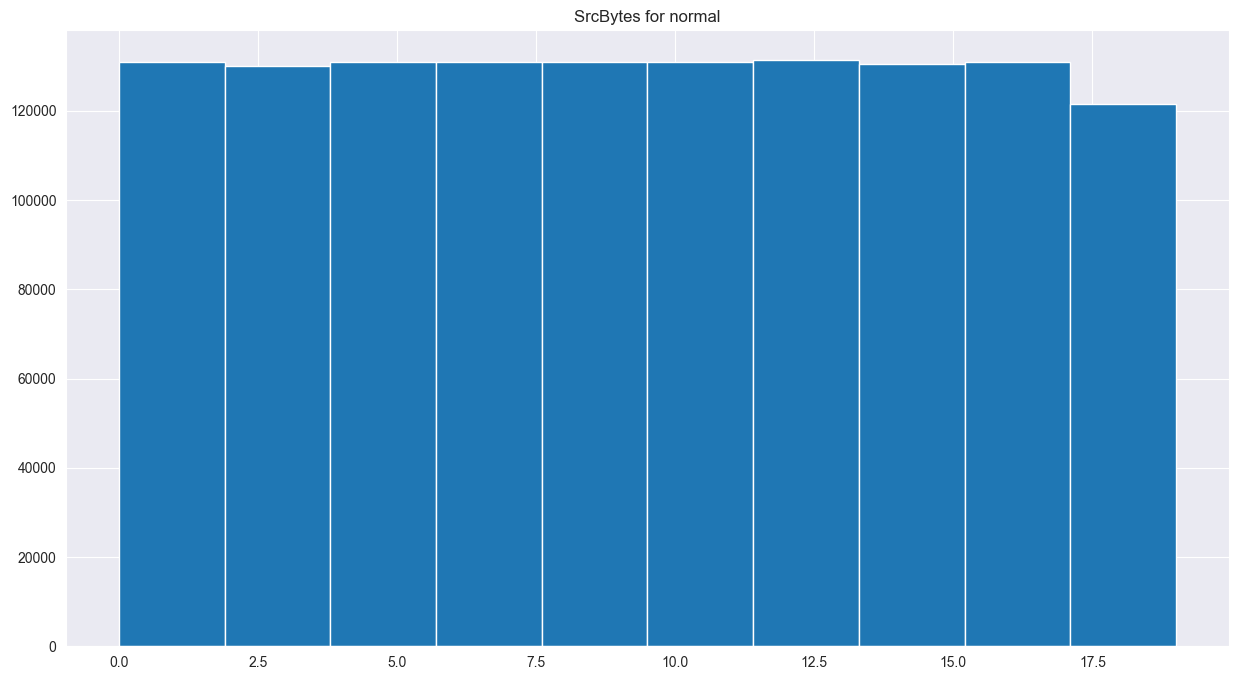

In [64]:
# Let's start by visualizing the 'SrcBytes' and 'duration' features
print('for infected: ')
numeric_cols_infected[['SrcBytes', 'Dur']].hist(bins=10, figsize=(15, 8))
plt.show()
print('for normal: ')
numeric_cols_other[['SrcBytes', 'Dur']].hist(bins=10, figsize=(15, 8))
plt.show()

numeric_cols_infected[['bytes_per_second']].hist(bins=10, figsize=(15, 8))
plt.title('SrcBytes for infected')
numeric_cols_other[['bytes_per_second']].hist(bins=10, figsize=(15, 8))
plt.title('SrcBytes for normal')

plt.show()


### 1c. Answers and explanation

We found a big difference in SrcBytes and Duration between infected hosts and normal hosts. The infected hosts send a lot of bytes in a short amount of time. That is why we create a bytes per second column which combines the two features into one and strengthens the effect. We did the discretion using percentile since this divides the values evenly over the bins which makes sure that there is not one bin with most values in there so there is little difference between the different connections. We chose 20 bins since this is a default and doing more would make the values to rare which would increase the size of the state-symbol combinations making all ip-addresses less similar and doing less would make the decrease the difference between ip-addresses which would make it more difficult to seperate them from each other.

## 4.Botnet profiling and fingerprinting task

### 4a. Learn a sequential model, profiling and fingerprinting

### Learn model on infected host

In [65]:
def create_flexfringe(df1):
    botnet_ip = infected_hosts[0]
    df_tracefile = df1[df1['SrcAddr'] == botnet_ip]
    df_tracefile = df_tracefile.rename(columns={"bytes_per_second": "symb"})[['symb']]
    flexfringe = FlexFringe(
        flexfringe_path="flexfringe-x64-windows.exe",
        heuristic_name="alergia",
        data_name="alergia_data",
        slidingwindow=1,
        swsize=10,
        sinkson=1,
        sinkcount=50,
        printblue=1,
        printwhite=1,
    )
    # Learn a state machine
    flexfringe.fit(df_tracefile,
                   sinkson=1,
                   sinkcount=50)
    flexfringe.show()
    return flexfringe

### Profiling

In [66]:
def make_profile(flex_fringe, trace_file):
    # Use state machine to predict likelihoods
    df = flex_fringe.predict(trace_file)
    return df[['abbadingo trace', 'state sequence']]

def create_profiles(df1, flexfringe):
    df1_profiling = df1[['SrcAddr', 'bytes_per_second']]
    df1_profiling = df1_profiling.rename(columns={"bytes_per_second": "symb"})
    # Filter out src addresses that have less than 20 connections
    df1_profiling = df1_profiling.groupby('SrcAddr').filter(lambda x: len(x) >= 20)
    # Get the unique values in the 'SrcAddr' column
    unique_src_addrs = df1_profiling['SrcAddr'].unique()
    src_addr_with_state_trace = []
    # Iterate over each unique 'SrcAddr' value
    for src_addr in tqdm(unique_src_addrs, maxinterval=len(unique_src_addrs)):
        # Filter the dataframe based on the current 'SrcAddr' value
        filtered_df = df1_profiling[df1_profiling['SrcAddr'] == src_addr]
        trace_state = make_profile(flexfringe, filtered_df)
        src_addr_with_state_trace.append([src_addr, trace_state])
    return src_addr_with_state_trace

In [67]:
def create_counts(src_addr_with_state_trace):
    # Create an empty dictionary to store the counts
    counts = {}

    # Iterate over each IP address and corresponding DataFrame
    for item in tqdm(src_addr_with_state_trace, maxinterval=len(src_addr_with_state_trace)):
        ip_address = item[0]
        dataframe = item[1]

        # Iterate over each row in the DataFrame
        for _, row in dataframe.iterrows():
            states = row['state sequence']
            trace = row['abbadingo trace']

            # Get the shorter length between state sequence and abbadingo trace
            length = min(len(states), len(trace))

            # Iterate over each state and symbol combination
            for i in range(length):
                state = states[i]
                symbol = trace[i]

                # Cut off the state if it reaches -1
                if state == -1:
                    break

                # Create a tuple representing the state and symbol combination
                combination = (state, symbol)

                # Update the counts dictionary
                if ip_address in counts:
                    if combination in counts[ip_address]:
                        counts[ip_address][combination] += 1
                    else:
                        counts[ip_address][combination] = 1
                else:
                    counts[ip_address] = {combination: 1}

    # Create a DataFrame from the counts dictionary
    df_counts = pd.DataFrame(counts).fillna(0).astype(int).transpose()

    # Sort the columns in ascending order
    df_counts = df_counts.reindex(sorted(df_counts.columns),axis=1)
    return df_counts

In [68]:
def print_false_postives(df_cos_sim, botnet_ip, infected_hosts):
    threshold = 0.999
    print('false positives for threshold: ', threshold)
    print()
    for index in df_cos_sim[df_cos_sim[botnet_ip] > threshold][botnet_ip].index:
        if index not in infected_hosts:
            print(index)
            print(df_cos_sim[df_cos_sim[botnet_ip] > threshold][botnet_ip][index])
            print()

In [69]:
def create_cosine_matrix(df_counts, botnet_ip, printing, infected_hosts):
    cos_sim_matrix = cosine_similarity(df_counts)
    # Convert the cosine similarity matrix to a DataFrame
    df_cos_sim = pd.DataFrame(cos_sim_matrix, index=df_counts.index, columns=df_counts.index)
    if printing:
        print('similarity scores for infected hosts')
        for ip_address in infected_hosts:
            print(ip_address)
            print(df_cos_sim.loc[botnet_ip, ip_address])
            print()
        print_false_postives(df_cos_sim, botnet_ip, infected_hosts)

In [70]:
def show_similarity_plot(df_counts, botnet_ip, ip_addresses = ['147.32.84.192', '147.32.96.45', '147.32.87.16'], correctness = ['true positive', 'true negative', 'false positive']):
    # Get the occurrences for the botnet_ip row
    botnet_occurrences = df_counts.loc[botnet_ip]

    # Get the occurrences for the given IP addresses
    ip_occurrences = df_counts.loc[ip_addresses]

    for ip_address in ip_addresses:
        x = botnet_occurrences
        y = ip_occurrences.loc[ip_address]
        # Calculate the coefficients of the regression line (y = mx + c)
        coefficients = np.polyfit(x, y, 1)
        m = coefficients[0]  # Slope
        c = coefficients[1]  # Intercept

        # Generate points for the regression line
        regression_x = np.linspace(min(x), max(x), 100)
        regression_y = m * regression_x + c

        # Plot the data points and the regression line
        plt.scatter(x, y, label=correctness[ip_addresses.index(ip_address)])
        plt.plot(regression_x, regression_y, label=ip_address)

    plt.plot(botnet_occurrences, botnet_occurrences, color='r', linestyle='--', label= 'botnet')
    plt.xlabel('Occurrences for Botnet IP')
    plt.ylabel('Occurrences for Other IP Addresses')
    plt.xlim(-50, 18000)
    plt.ylim(-50, 18000)
    plt.legend()
    # Show the plot
    plt.show()


In [71]:
def find_fingerprints(df_counts):
    # Separate the infected and non-infected IP addresses
    infected_ips = set(infected_hosts)
    non_infected_ips = set(df_counts.index) - infected_ips

    # Calculate the occurrence percentages and counts for each state-symbol combination in infected and non-infected IP addresses
    occurrence_infected = (df_counts.loc[infected_ips] > 0).mean()
    occurrence_non_infected = (df_counts.loc[non_infected_ips] > 0).mean()
    total_count_infected = df_counts.loc[infected_ips].sum()
    total_count_non_infected = df_counts.loc[non_infected_ips].sum()

    # Filter state-symbol combinations that meet the conditions
    significant_combinations = occurrence_infected[(occurrence_infected >= 1) & (occurrence_non_infected < 0.01)]

    # Print the significant combinations along with their occurrence percentages and total counts
    print("Significant state-symbol fingerprints:")
    for combination, occurrence in significant_combinations.iteritems():
        print("Combination:", combination)
        print("Occurrence in infected IP addresses: {:.2f}%".format(occurrence * 100))
        print("Occurrence in non-infected IP addresses: {:.2f}%".format(occurrence_non_infected[combination] * 100))
        print()

dataframe  9 :


100%|██████████| 981/981 [00:11<00:00, 82.29it/s] 


similarity scores for infected hosts
147.32.84.165
1.0000000000000018

147.32.84.191
0.9999900043779933

147.32.84.192
0.9999956656280344

147.32.84.193
0.9999888096848317

147.32.84.204
0.9999871119510997

147.32.84.205
0.9999450616815674

147.32.84.206
0.999936303595828

147.32.84.207
0.9998822078009846

147.32.84.208
0.9999083125847313

147.32.84.209
0.9996175971408506

false positives for threshold:  0.999

147.32.87.16
0.9996102797152897

192.168.88.153
0.9994956336745656



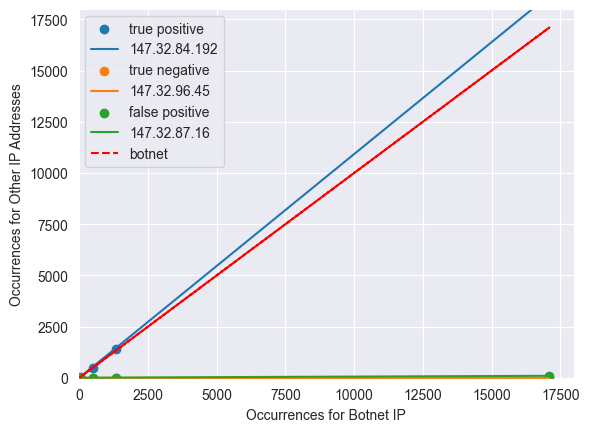

C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_infected = (df_counts.loc[infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_non_infected = (df_counts.loc[non_infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_infected = df_counts.loc[infected_ips].sum()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_non_infected = df_counts.loc[non_infected_ips].sum()
C:\Users\ottev\

Significant state-symbol fingerprints:
Combination: ('95', '18')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.62%

dataframe  10 :


100%|██████████| 981/981 [00:14<00:00, 69.59it/s] 


similarity scores for infected hosts
147.32.84.165
1.0000000000000018

147.32.84.191
0.9999900043779933

147.32.84.192
0.9999956656280344

147.32.84.193
0.9999888096848317

147.32.84.204
0.9999871119510997

147.32.84.205
0.9999450616815674

147.32.84.206
0.999936303595828

147.32.84.207
0.9998822078009846

147.32.84.208
0.9999083125847313

147.32.84.209
0.9996175971408506

false positives for threshold:  0.999

147.32.87.16
0.9996102797152897

192.168.88.153
0.9994956336745656



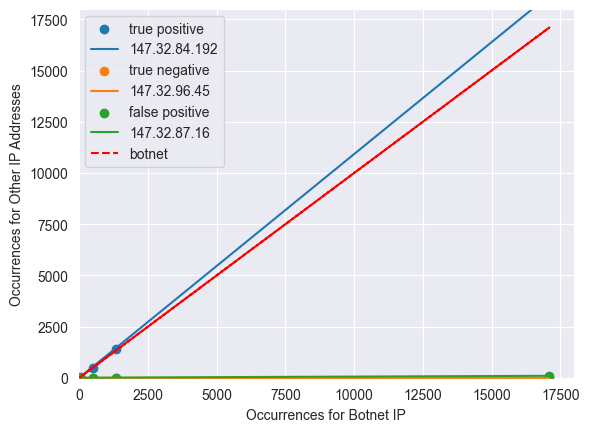

C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_infected = (df_counts.loc[infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_non_infected = (df_counts.loc[non_infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_infected = df_counts.loc[infected_ips].sum()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_non_infected = df_counts.loc[non_infected_ips].sum()
C:\Users\ottev\

Significant state-symbol fingerprints:
Combination: ('95', '18')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.62%

dataframe  11 :


100%|██████████| 981/981 [00:15<00:00, 64.39it/s] 


similarity scores for infected hosts
147.32.84.165
1.0000000000000018

147.32.84.191
0.9999900043779933

147.32.84.192
0.9999956656280344

false positives for threshold:  0.999

147.32.87.16
0.9996102797152897

147.32.84.193
0.9999888096848317

147.32.84.204
0.9999871119510997

147.32.84.205
0.9999450616815674

147.32.84.206
0.999936303595828

147.32.84.207
0.9998822078009846

147.32.84.208
0.9999083125847313

147.32.84.209
0.9996175971408506

192.168.88.153
0.9994956336745656



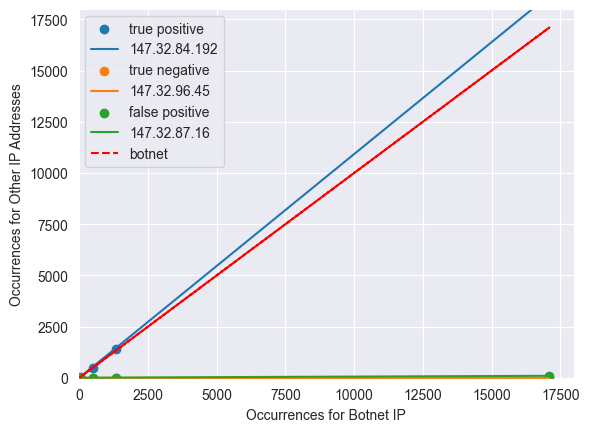

C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_infected = (df_counts.loc[infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_non_infected = (df_counts.loc[non_infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_infected = df_counts.loc[infected_ips].sum()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_non_infected = df_counts.loc[non_infected_ips].sum()
C:\Users\ottev\

Significant state-symbol fingerprints:
Combination: ('126', '18')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.92%

Combination: ('62', '18')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.31%

dataframe  12 :


100%|██████████| 981/981 [00:13<00:00, 73.91it/s] 


similarity scores for infected hosts
147.32.84.165
1.0000000000000018

147.32.84.191
0.9999900043779933

147.32.84.192
0.9999956656280344

false positives for threshold:  0.999

147.32.87.16
0.9996102797152897

147.32.84.193
0.9999888096848317

147.32.84.204
0.9999871119510997

147.32.84.205
0.9999450616815674

147.32.84.206
0.999936303595828

147.32.84.207
0.9998822078009846

147.32.84.208
0.9999083125847313

147.32.84.209
0.9996175971408506

192.168.88.153
0.9994956336745656



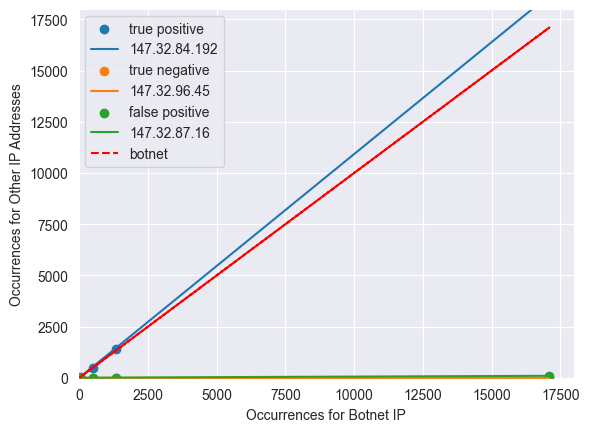

Significant state-symbol fingerprints:
Combination: ('126', '18')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.92%

Combination: ('62', '18')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.31%



C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_infected = (df_counts.loc[infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_non_infected = (df_counts.loc[non_infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_infected = df_counts.loc[infected_ips].sum()
C:\Users\ottev\AppData\Local\Temp\ipykernel_18604\3604257517.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_non_infected = df_counts.loc[non_infected_ips].sum()
C:\Users\ottev\

In [72]:
infected_hosts_9_10 = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193','147.32.84.204', '147.32.84.205', '147.32.84.206','147.32.84.207', '147.32.84.208', '147.32.84.209']
infected_hosts_11_12 = ['147.32.84.165', '147.32.84.191', '147.32.84.192']
infected_hosts_list = [infected_hosts_9_10, infected_hosts_9_10, infected_hosts_11_12, infected_hosts_11_12]
dataframes = [df9, df10, df11, df12]
for i, dataframe in enumerate(dataframes):
    print('dataframe ', i + 9, ':')
    infected_hosts = infected_hosts_list[i]
    botnet_ip = infected_hosts[0]
    flexfringe = create_flexfringe(df10)
    src_addr_with_state_trace =  create_profiles(df10, flexfringe)
    df_counts = create_counts(src_addr_with_state_trace)
    create_cosine_matrix(df_counts, botnet_ip, True, infected_hosts)
    show_similarity_plot(df_counts, botnet_ip)
    find_fingerprints(df_counts)
    print('----------------------------------------------')

### 4b. Analysis and answers to the questions.

The false positive found for profiling has to with the number of state-symbol combinations that is 0 for the botnet that the profiling is trained on. Most of the combination have 0 occurrences for all the ip-addresses which makes the similarity score already high by default. The reason that this the depicted false positive has a higher score than other normal ip-addresses is because of the combination that occurs around 17500 times for the botnet and around 93 times for the false positive. This is more than the other normal ip-addresses and therefor gets a high similarity score. The true positive depicted has a lot of similar counts for all state-symbol combinations.

The false positve we found for the above tasks for the fingerting is there because that state symbol combination exists in the path for the infected IP addresses (true positives) but rare in non-infected ones. True positives occur when such combinations appear in infected IPs and we deem a combination significant if it occurs in 100% of infected IPs. False positives, however, arise when these significant combinations also show up in non-infected IPs. We try to mitigate this by filtering out combinations present in over 1% of non-infected IPs. Still, a significant combination occurring in less than 1% of non-infected IPs have lead to false positives.
